# Watermarks Delete

In [13]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
from tqdm import tqdm
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


In [6]:
data_v = "data/base_dataset"
data_w = "data/watermarked_dataset"

# UNet PyTorch

## Dataloader

In [ ]:
class WatermarkDataset(Dataset):
    def __init__(self, base_folder, watermarked_folder, transform=None):
        self.base_folder = base_folder
        self.watermarked_folder = watermarked_folder
        self.transform = transform
        self.base_images = os.listdir(base_folder)
        self.watermarked_images = os.listdir(watermarked_folder)

    def __len__(self):
        return len(self.base_images)

    def __getitem__(self, idx):
        base_image_path = os.path.join(self.base_folder, self.base_images[idx])
        watermarked_image_path = os.path.join(self.watermarked_folder, self.watermarked_images[idx])

        base_image = Image.open(base_image_path).convert("RGB")
        watermarked_image = Image.open(watermarked_image_path).convert("RGB")

        if self.transform:
            base_image = self.transform(base_image)
            watermarked_image = self.transform(watermarked_image)

        return base_image, watermarked_image
    
    def create_small_dataset(self, n):
            num_samples = len(self.base_images)
            sample_size = int(num_samples * n)
            
            indices = torch.randperm(num_samples)[:sample_size]
            
            return Subset(self, indices)

def get_dataloaders(base_folder, watermarked_folder, batch_size=32, transform=None, small_dataset=False, n=0.1):
    dataset = WatermarkDataset(base_folder, watermarked_folder, transform)
    
    if small_dataset:
        dataset = dataset.create_small_dataset(n)
        
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader

In [ ]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

train_loader = get_dataloaders('data/base_dataset', 'data/watermarked_dataset', transform=transform, small_dataset=True)

In [9]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

In [ ]:
class WatermarkRemovalUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super(WatermarkRemovalUNet, self).__init__()
        
        # Encoder
        self.encoder1 = DoubleConv(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.encoder2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.encoder3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.encoder4 = DoubleConv(256, 512)
        self.pool4 = nn.MaxPool2d(2)
        
        self.bottom = DoubleConv(512, 1024)
        
        # Decoder
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.decoder4 = DoubleConv(1024, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder3 = DoubleConv(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder2 = DoubleConv(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder1 = DoubleConv(128, 64)
        
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)
        
    def forward(self, x):
        # Encoder
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))
        
        bottom = self.bottom(self.pool4(enc4))
        
        # Decoder
        dec4 = self.upconv4(bottom)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)
        
        return self.final_conv(dec1)

def watermark_loss(output, target, watermarked):
    reconstruction_loss = F.mse_loss(output, target)
    
    watermark_diff_loss = F.mse_loss(output, watermarked)
    
    return reconstruction_loss + 0.1 * watermark_diff_loss

def train_watermark_removal(model, train_loader, epochs=5, lr=0.001):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        
        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}', unit='batch')
        
        for clean_images, watermarked_images in progress_bar:
            clean_images = clean_images.to(device)
            watermarked_images = watermarked_images.to(device)
            
            optimizer.zero_grad()
            
            output = model(watermarked_images)
            
            loss = F.mse_loss(output, clean_images)
            
            loss.backward()
            optimizer.step()
            
            total_train_loss += loss.item()
            
            progress_bar.set_postfix({'Loss': loss.item()})
        
        avg_loss = total_train_loss / len(train_loader)
        print(f"Epoch {epoch+1} - Average Loss: {avg_loss:.4f}")

In [ ]:
model = WatermarkRemovalUNet()
train_watermark_removal(model, train_loader)

Epoch 1/10: 100%|██████████| 7/7 [03:23<00:00, 29.11s/batch, Loss=0.0398]


Epoch 1 - Average Loss: 0.1586


Epoch 2/10: 100%|██████████| 7/7 [03:21<00:00, 28.76s/batch, Loss=0.0056] 


Epoch 2 - Average Loss: 0.0135


Epoch 3/10: 100%|██████████| 7/7 [03:18<00:00, 28.33s/batch, Loss=0.00619]


Epoch 3 - Average Loss: 0.0072


Epoch 4/10: 100%|██████████| 7/7 [03:24<00:00, 29.24s/batch, Loss=0.00287]


Epoch 4 - Average Loss: 0.0046


Epoch 5/10: 100%|██████████| 7/7 [03:16<00:00, 28.06s/batch, Loss=0.00241]


Epoch 5 - Average Loss: 0.0031


Epoch 6/10: 100%|██████████| 7/7 [03:15<00:00, 27.94s/batch, Loss=0.00274]


Epoch 6 - Average Loss: 0.0029


Epoch 7/10: 100%|██████████| 7/7 [03:14<00:00, 27.74s/batch, Loss=0.00233]


Epoch 7 - Average Loss: 0.0024


Epoch 8/10: 100%|██████████| 7/7 [03:15<00:00, 27.87s/batch, Loss=0.00171]


Epoch 8 - Average Loss: 0.0023


Epoch 9/10: 100%|██████████| 7/7 [03:17<00:00, 28.18s/batch, Loss=0.00205]


Epoch 9 - Average Loss: 0.0020


Epoch 10/10: 100%|██████████| 7/7 [03:19<00:00, 28.44s/batch, Loss=0.00265]

Epoch 10 - Average Loss: 0.0025


## Enregistrement du modèle

In [ ]:
model_path = 'watermark_removal_model.pth'

torch.save(model.state_dict(), model_path)

## Test

In [24]:
def test_model(model_path, test_loader):
    model = WatermarkRemovalUNet()
    model.load_state_dict(torch.load(model_path))
    model.eval()
    
    with torch.no_grad():
        for clean_images, watermarked_images in test_loader:
            clean_images = clean_images
            watermarked_images = watermarked_images
            
            output = model(watermarked_images)
            
            for i in range(5):
                fig, axs = plt.subplots(1, 3, figsize=(15, 5))
                
                axs[0].imshow(watermarked_images[i].cpu().permute(1, 2, 0))
                axs[0].set_title('Image avec watermark')
                axs[0].axis('off')
                
                axs[1].imshow(output[i].cpu().permute(1, 2, 0))
                axs[1].set_title('Image après suppression du watermark')
                axs[1].axis('off')
                
                axs[2].imshow(clean_images[i].cpu().permute(1, 2, 0))
                axs[2].set_title('Image originale')
                axs[2].axis('off')
                
                plt.show()

/var/folders/f2/jkvc9s6x039dm5cg4ch3shvh0000gn/T/ipykernel_19099/3130831715.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))

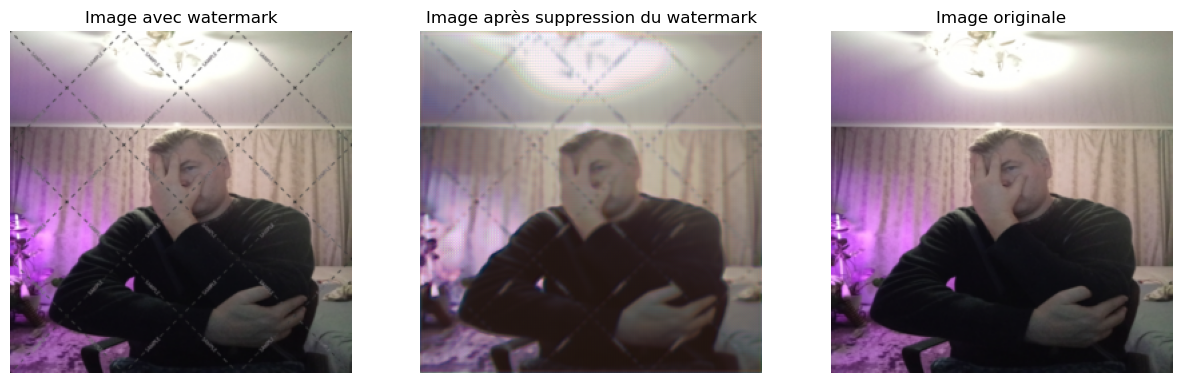

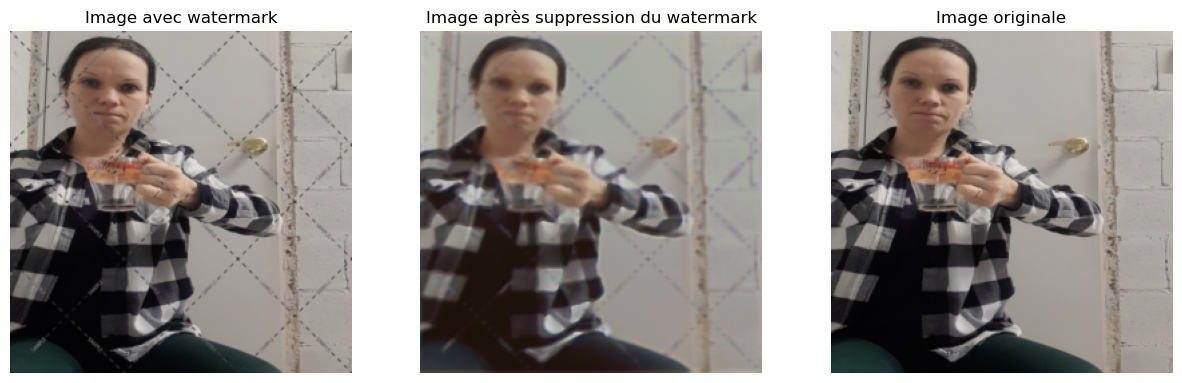

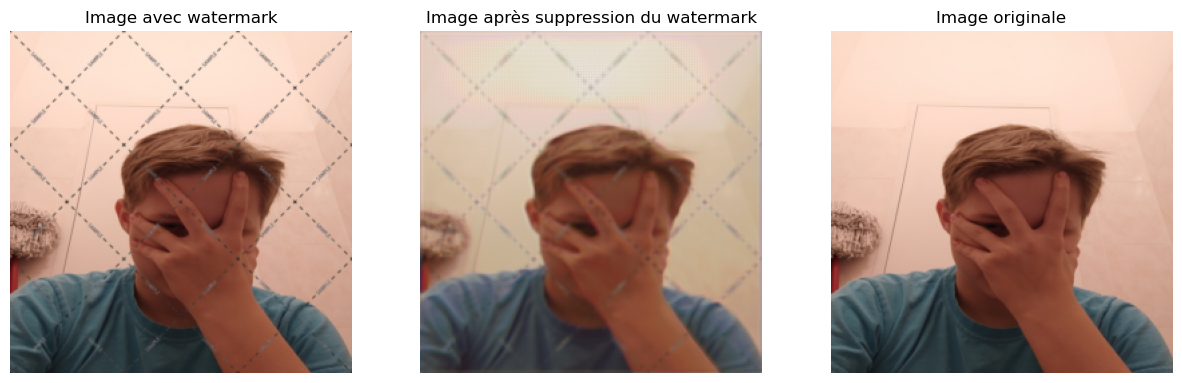

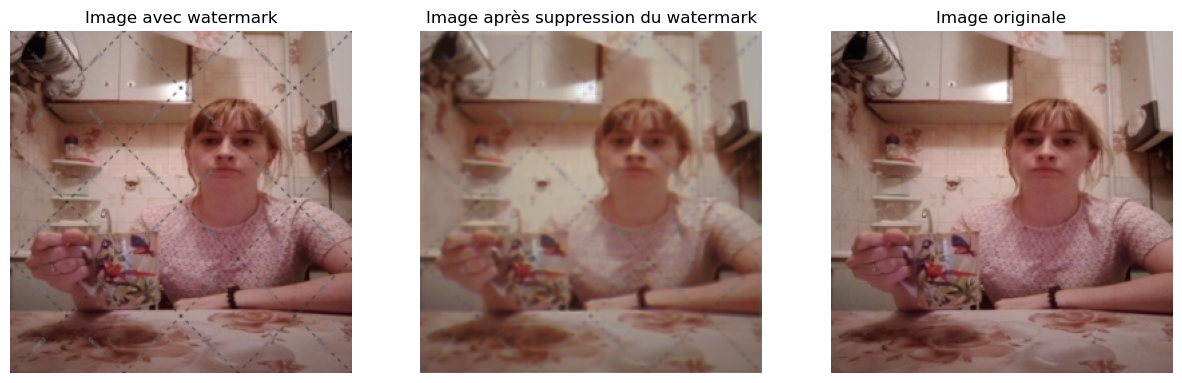

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.1629198..1.0125531].


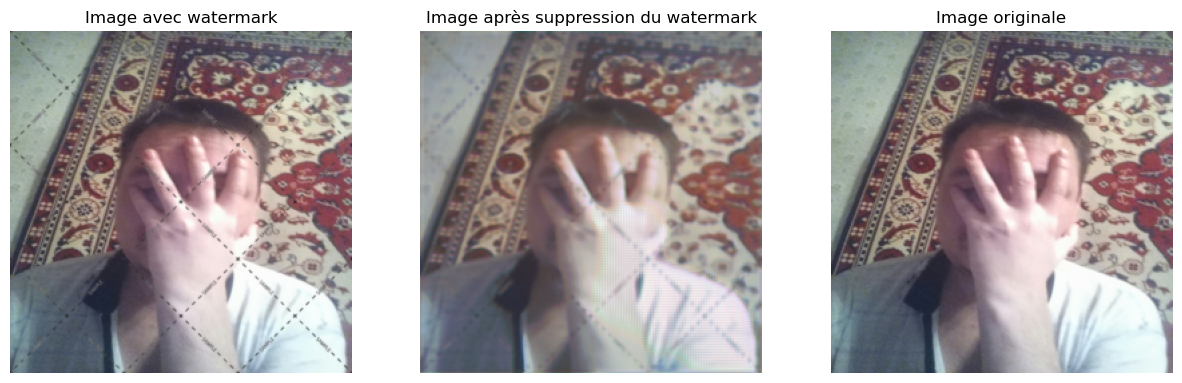

KeyboardInterrupt: 

In [25]:
test_loader = get_dataloaders('data/base_dataset', 'data/watermarked_dataset', transform=transform, small_dataset=True)
test_model(model_path, test_loader)